# MAPPING A TEMPERATURE MAP ONTO THE SKY

In [1]:
# This cells gives formatting to the images embedded in this Notebook
from IPython.core.display import HTML
HTML("""
<style>
img[alt=image] { width: 300px; }
</style>
""");

In this example we will work with observations of the Cosmic Microwave Background from the Planck satellite using advanced functionalities of `pandas` and `numpy` and we will create plots with `matplotlib`.

In section 1 we will read a map created by the Planck satellite and we will familiarize with HDF5 format and working with hierarchical indexing in `pandas`. We will also visualize sky maps in `matplotlib` using a curvilinear projection.


## The Planck satellite

[Planck](http://www.esa.int/Our_Activities/Space_Science/Planck_overview) is a Space Mission by the European Space Agency in collaboration with NASA. Its purpose is to measure the Cosmic Microwave Background; the relic radiation, originated just 300,000 years after the Big Bang, is a pillar in understanding how the Universe was born and how it evolved into its current state.

In this Notebook we will create a simulation of the Planck data using advanced functionalities of `pandas`.
![image](http://www.esa.int/var/esa/storage/images/esa_multimedia/images/2009/03/planck_being_prepared_for_tests/9836424-3-eng-GB/Planck_being_prepared_for_tests.jpg)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1) Load and visualize a map created by the Planck satellite

The Planck satellite has several frequency channels between 30 GHz and 857 GHz, let's choose one of the middle channels which are the cleanest channels to investigate the Cosmic Microwave Background: 70 GHz.

I prepared a dataset from the official Planck 70 GHz map located at <http://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/>, it is available in the current repository

Let's use `!` to execute a shell command (`ls`) in the current folder to check that the file is available:

In [3]:
!ls ./Data/planck*

./Data/planck_70GHz_map.hdf5


### 1.1) HDF5

[`HDF5`](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a binary file format extremely efficient in storing scientific data. It is very convenient because it stores also metadata about the file content and can have a hierarchical structure. It is currently the more efficient general purpose file format in terms of space (it supports several compression algorithms) and reading speed (it also supports parallel access on Supercomputers).

The first advanced `pandas` feature is reading and writing `pd.Series` and `pd.DataFrames` to `HDF5` with `read_hdf` and `to_hdf`.

Let's read the map from `HDF5` into a `pandas` object:

In [4]:
planck_map = pd.read_hdf("./Data/planck_70GHz_map.hdf5")

The more portable way to save a `pd.DataFrame` to disk is `HDF5`, `pickle` is another binary format but does not always work the same way on different platforms, `CSV` is text-based so it is an option only for small datasets.

In [8]:
type(planck_map)

pandas.core.series.Series

It is a `pd.Series`, in fact it is only 1 column of data: **Temperature of the sky in Kelvin degrees**, let's inspect this object:

The length of the dataset is

In [6]:
len(planck_map)

64800

but how are those points organized?

`pandas` objected are organized with their `index`, which is a label attached to every data point.

In [9]:
type(planck_map.index)

pandas.core.indexes.multi.MultiIndex

In [8]:
planck_map.head()

latitude  longitude
-90       -180         0.000063
          -179         0.000063
          -178         0.000063
          -177         0.000063
          -176         0.000063
Name: temperature, dtype: float64

In [9]:
planck_map.tail()

latitude  longitude
90        176          0.000026
          177          0.000026
          178          0.000026
          179          0.000026
          180         -0.000038
Name: temperature, dtype: float64

Each element in the dataset is a temperature of the sky in the direction given by the latitude and longitude stored in the Index.
Latitude is from -90 degrees below the Galactic plane to 90 degrees above the Galactic plane in steps of 1 degree, pretty much like the North and South Poles on Earth.
For each Latitude point, Longitude spans from -180 degrees to 180 degrees in steps of 1 degrees.

### 1.2) Hierarchical indexing

The second advanced feature of `pandas` is `pd.MultiIndex`, it is a way to setup a hierarchical indexing, in this case we have a rectangular grid of latitudes and longitudes with sizes:

In [12]:
list(zip(planck_map.index.names, planck_map.index.levshape))

[('latitude', 180), ('longitude', 360)]

in Galactic coordinates (latitude 0 is the Galactic Plane). For each value of latitude, for example 15 degrees above the Galactic plane, we have longitudes running from -180 to 180 degrees:

Ana: <span style="color:purple">Dado que los puntos del dominio aumentan de 1 en 1, la etiqueta de la primera capa es literalmente la longitud mientras que las de la segunda capa son la longitud</span>

In [34]:
planck_map.loc[15]

longitude
-180    0.000182
-179    0.000111
-178    0.000080
-177    0.000078
-176    0.000099
          ...   
 176    0.000354
 177    0.000211
 178    0.000003
 179    0.000083
 180    0.000182
Name: temperature, Length: 360, dtype: float64

### 1.3) Plot slices of the dataset

In this section we will plot some slices of the data in Longitude and Latitude.

First we call the `%matplotlib inline` magic function of Jupyter to set the plots to be displayed inside the Notebook.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

Then we can use `.loc` to extract a part of the data based on the value of the Index, in the case of a `MultiIndex`, if we provide only 1 value, that means the higher level of the Index, i.e. Latitude.

The following plot shows the emission 2 degrees above the Galactic Plane, we can easily identify extremely bright sources in the Microwave regime sitting close to the plane:

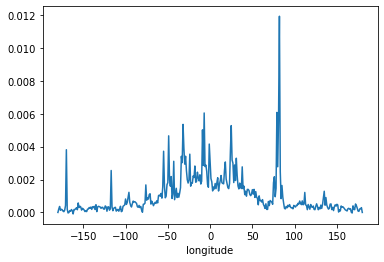

In [23]:
#planck_map.loc[1].plot()
planck_map.loc[1].plot()

We can also overplot the emission at increasing Latitudes to check how the strong emission of the Galaxy fades away at higher latitudes:

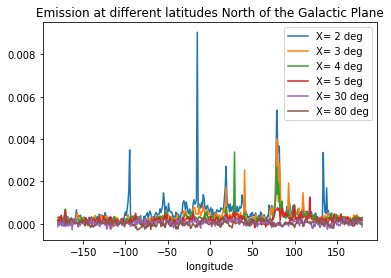

In [24]:
for lat in [2,3,4,5,30, 80]:
    planck_map.loc[lat].plot(label="X= {} deg".format(lat))
plt.title("Emission at different latitudes North of the Galactic Plane")
plt.legend();

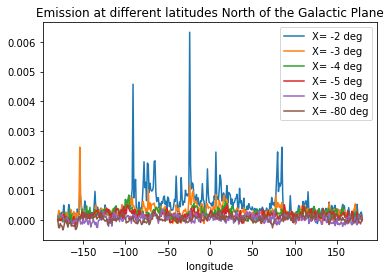

In [25]:
for lat in [-2,-3,-4,-5,-30, -80]:
    planck_map.loc[lat].plot(label="X= {} deg".format(lat))
plt.title("Emission at different latitudes North of the Galactic Plane")
plt.legend();

Using the same syntax we can instead plot a slice at a fixed Longitude, for example 1 degree and we can clearly identify the Galactic plane around Latitude 0.

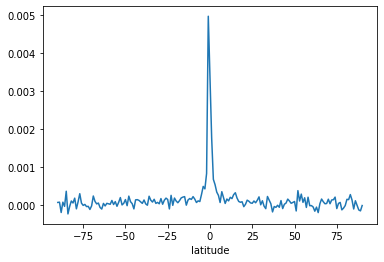

In [27]:
planck_map.loc[:, 15].plot();

### 1.4) Plot a map of the sky



One dimensional line plots are easy, just call the `.plot` function of any `pd.Series`, what we would like to achieve in this section is to plot the entire sky.

#### 1.4.1) Unstacking

The third advanced `pandas` feature is unstacking. It is the operation of transforming a dataset with a `pd.MultiIndex` into a 2 dimensional array.
Easier to look at it in action:

In [6]:
map_2d = planck_map.unstack()

In [7]:
map_2d.head()

longitude,-180,-179,-178,-177,-176,-175,-174,-173,-172,-171,...,171,172,173,174,175,176,177,178,179,180
latitude,,,,,,,,,,,,,,,,,,,,,
-90,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,...,1.238379e-04,0.000124,0.000124,0.000124,0.000124,0.000124,1.238379e-04,0.000124,0.000124,0.000063
-89,-0.000219,-0.000124,-0.000124,-0.000124,-0.000124,-0.000182,-0.000182,-0.000182,-0.000182,-0.000059,...,-1.856506e-04,-0.000058,-0.000058,-0.000058,-0.000058,-0.000157,-1.573854e-04,-0.000157,-0.000157,-0.000219
-88,-0.000195,-0.000197,-0.000197,-0.000180,-0.000180,-0.000187,-0.000187,-0.000031,-0.000031,-0.000151,...,-2.182215e-04,-0.000271,-0.000271,-0.000182,-0.000182,-0.000317,-3.167214e-04,-0.000300,-0.000300,-0.000195
-87,-0.000153,-0.000168,-0.000124,-0.000310,-0.000310,-0.000181,-0.000041,-0.000124,-0.000124,-0.000094,...,-5.043610e-07,-0.000067,-0.000067,-0.000141,-0.000148,-0.000155,-1.547419e-04,-0.000245,-0.000123,-0.000153
-86,0.000150,0.000160,0.000166,0.000011,0.000129,0.000115,0.000146,0.000033,0.000134,0.000097,...,2.905639e-05,0.000109,0.000148,-0.000060,0.000052,-0.000086,-8.843734e-07,0.000151,0.000016,0.000150


In [31]:
map_2d.columns

Int64Index([-180, -179, -178, -177, -176, -175, -174, -173, -172, -171,
            ...
             171,  172,  173,  174,  175,  176,  177,  178,  179,  180],
           dtype='int64', name='longitude', length=360)

The unstacking operation is keeping the higher level of the `pd.MultiIndex`, Latitude, as the index and it is transforming the inner level of the index into Columns, therefore the output is a `pd.DataFrame` with 180 rows and 360 columns.

In [55]:
map_2d.shape

(180, 360)

Therefore we have transformed the initial dataset that was stored in a dimensional object into a 2 dimensional representation.

This is exactly what we need to plot it.
As a first step, we can just plot the 2d array as it is with `imshow`, which uses a colorscale to plot a 2d array based on the amplitude at each point.
We just need to set a minimum and maximum extreme of the scale with `vmin` and `vmax`, +-1 milliKelvin range, 1/1000 K is good for our purposes:

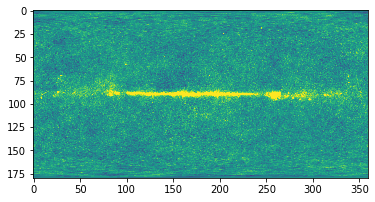

In [36]:
plt.imshow(map_2d, vmin=-0.7e-3, vmax=0.7e-3);

The plot shows latitude vertically and longitude horizontally, we can identify the galactic plane emission at the center of the map, most of the rest of the map shows the fluctuations of the Cosmic Microwave Background and some residual noise.

Below is a map from the European Space Agency with **only** the Cosmic Microwave Background (CMB) detected by Planck by combining all the different frequencies together and separating out the Galactic emission to help your eyes look for similar patterns in the data above:

![image](http://www.esa.int/var/esa/storage/images/esa_multimedia/images/2013/03/planck_cmb/12583930-4-eng-GB/Planck_CMB.jpg)

The representation of a full sky map as a rectangle is quite misleading, we are displaying temperatures of data in a sphere, similar to maps of the Earth.

Cosmologists like to use the `Mollweide` projection because it preserves the area, which is one of the most important things when studing the CMB. The above map of the CMB by Planck is in Mollweide projection. See for example a [map of the Earth in Mollweide projection on Wikipedia](https://en.wikipedia.org/wiki/Mollweide_projection#/media/File:Mollweide_projection_SW.jpg).

Let's also plot our map the Cosmology way, first we extract Longitude and Latitude from the index:

In [25]:
latitude, longitude = planck_map.index.levels

In [26]:
longitude

Int64Index([-180, -179, -178, -177, -176, -175, -174, -173, -172, -171,
            ...
             171,  172,  173,  174,  175,  176,  177,  178,  179,  180],
           dtype='int64', name='longitude', length=360)

`matplotlib` supports Mollweide projection natively, we just need the more advanced `pcolormesh` plotting function, which has a similar functionality to `imshow`, but also requires `x` and `y` coordinates in radians. For this reason we import `numpy` to use the `np.radians` function to convert degrees to radians.

**Note**: the convention used here to plot maps is the _Geo_ convention, i.e. Longitude increasing East, in Astrophysics is actually more common to use the _Astro_ convention,i.e. Longitude increasing West. Maps in these 2 formats are flipped left-right. 

In [29]:
def plot_mollweide_map(longitude, latitude, mapa, vmin=-.7e-3, vmax=.7e-3):
    fig = plt.figure(figsize=(10,20))
    ax = fig.add_subplot(111, projection="mollweide")
    plt.pcolormesh(np.radians(longitude), np.radians(latitude), mapa, vmin=vmin, vmax=vmax);

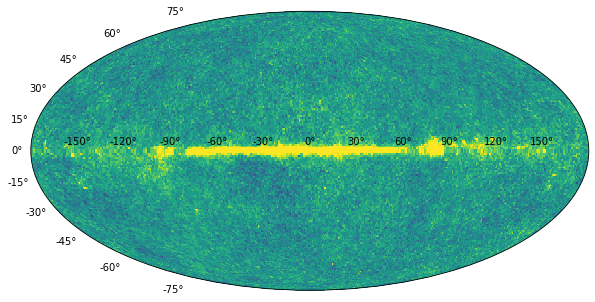

In [30]:
plot_mollweide_map(longitude, latitude, map_2d)

Finally we got a figure showing the full map we read from disk at the beginning of this example.

This map is a measurement of the brightness of the sky in the microwave regime looking in every direction around Earth, this data has been acquired by the Planck Satellite in over 4 years completing one full sky coverage every six months and then averaging all the data in a single map of the sky.

### 1.5) Masking the Galaxy

#### 1.5.1) Working with missing data

Very often analysis of the Cosmic Microwave Background requires masking of the Galaxy and other bright sources to avoid them contaminating the statistical properties of the rest of the sky.

There are mainly 2 strategies for quick&dirty masking, either a blind cut of data at low latitude or a cut based on the amplitude of the signal, let's try both on our map using `pandas`.

First we create a copy of the map and then slice the data in latitude and set the conventional symbol for missing data that is `np.nan` which stands for Not A Number.

`pandas` has several functionalities related to missing data, see [the documentation](http://pandas.pydata.org/pandas-docs/stable/missing_data.html).

In [31]:
cut_planck_map = planck_map.copy()

In [32]:
cut_planck_map.loc[-20:20,:] = np.nan

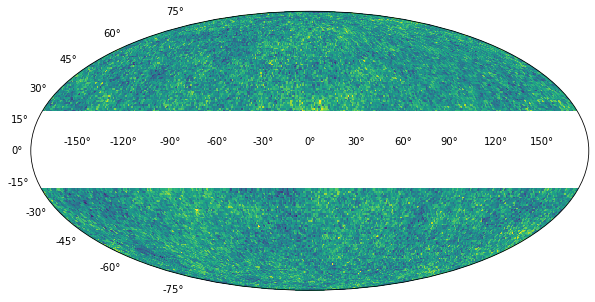

In [33]:
plot_mollweide_map(longitude,latitude,cut_planck_map.unstack(),vmin=-5e-4,vmax=5e-4)

A galactic cut is simple but not sophisticated enough, it masks a lot of low signal regions and leaves extragalactic sources and high latitude features of the Milky Way unmasked.

Let's try with a brightness cut instead, here we choose to mask all the points above a predefined threshold, we can tailor the threshold based on our knowledge of galactic emission.

See below how the syntax is very similar to pure `numpy` and creates a masked map that also covers sources outside of the galactic plane.

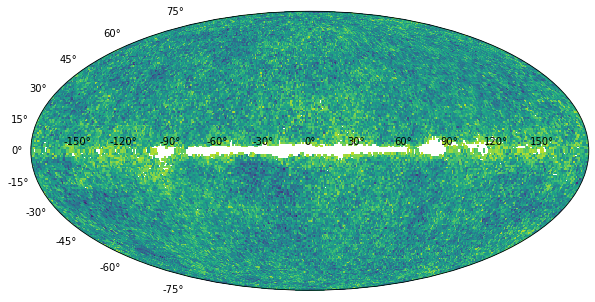

In [34]:
brightness_cut_planck_map = planck_map.copy()
brightness_cut_planck_map[brightness_cut_planck_map>.0004] = np.nan
plot_mollweide_map(longitude,latitude,brightness_cut_planck_map.unstack(),vmin=-5e-4,vmax=5e-4)